In [2]:
import fiftyone as fo
import json
from skimage.util import img_as_float
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import math
from pycocotools.coco import COCO
from sklearn import svm
from sklearn.model_selection import train_test_split
from skimage.segmentation import slic

# Constants
clear = 1.0
maybe = 0.5

def avgRgb(img):
    avgs = np.mean(img, axis=0)
    newAvgs = np.mean(avgs, axis=0)
    return newAvgs


# Takes in a COCO annotation file, image, and image ID: outputs an array containing the locations of Trezona pixels
def findAnns(annFile, id):
    coco = COCO(annFile)
    img = coco.imgs[id]
    catId = coco.getCatIds()
    annsId = coco.getAnnIds(imgIds=img['id'], catIds=catId, iscrowd=None)
    annsTemp = coco.loadAnns(annsId)

    annsArr = np.zeros((img['height'], img['width']))

    for ann in annsTemp:
        annsArr = np.maximum(annsArr, coco.annToMask(ann)*ann['category_id'])

    return annsArr


# Takes in an image and various parameters, outputs a SLIC image segmentation
def rgbSegment(image, channel, sig, compact):
    img = image[:, :, channel]
    segment = np.array(slic(img, sigma = sig, compactness = compact, channel_axis=None, n_segments=1000))
    return segment


# Takes in an image, its superpixel segmentations and annotations: 
# outputs an array of the R, G, B, and "Annotation Confidence" averages for each superpixel
def rgbProcess(image, anns, segment, avgs):
    numSegs = np.amax(segment)
    
    rgbArr = np.empty([numSegs, 7])

    for i in range(numSegs):
        sup = np.where(segment == i + 1)

        rAvg = np.mean(image[sup[0], sup[1], 0])
        gAvg = np.mean(image[sup[0], sup[1], 1])
        bAvg = np.mean(image[sup[0], sup[1], 2])
        segAvg = np.mean(anns[sup[0], sup[1]])

        rProm = np.mean(image[sup[0], sup[1], 0]) - avgs[0]
        gProm = np.mean(image[sup[0], sup[1], 1]) - avgs[1]
        bProm = np.mean(image[sup[0], sup[1], 2]) - avgs[2]

        rgbArr[i] = [rAvg, gAvg, bAvg, rProm, gProm, bProm, segAvg]

    return rgbArr

def noAnnProcess(image, segment, avgs):
    numSegs = np.amax(segment)
    
    rgbArr = np.empty([numSegs, 7])

    for i in range(numSegs):
        sup = np.where(segment == i + 1)

        rAvg = np.mean(image[sup[0], sup[1], 0])
        gAvg = np.mean(image[sup[0], sup[1], 1])
        bAvg = np.mean(image[sup[0], sup[1], 2])

        rProm = np.mean(image[sup[0], sup[1], 0]) - avgs[0]
        gProm = np.mean(image[sup[0], sup[1], 1]) - avgs[1]
        bProm = np.mean(image[sup[0], sup[1], 2]) - avgs[2]

        rgbArr[i] = [rAvg, gAvg, bAvg, rProm, gProm, bProm, 0.0]

    return rgbArr

# Takes in the predicted superpixel confidence levels and the original segmentation
# Outputs the confidence level for each individual pixel
def pixelate(pred, segment):
    pixelArr = np.empty([1544, 1595])
    
    for i in range(np.amax(segment)):
        ind = np.where(segment == i + 1)

        pixelArr[ind[0], ind[1]] = pred[i]

    return pixelArr

        




In [3]:

#Loading annotations/images
trainAnns1 = findAnns("Annotations/1599.json", 4)
trainAnns2 = findAnns("Annotations/1755.json", 3)
trainAnns3 = findAnns("Annotations/1893.json", 5)

trainAnns1[trainAnns1 == 6] = 1.0
trainAnns2[trainAnns2 == 6] = 1.0
trainAnns3[trainAnns3 == 6] = 1.0
trainAnns1[trainAnns1 == 7] = 0.25
trainAnns2[trainAnns2 == 7] = 0.25
trainAnns3[trainAnns3 == 7] = 0.25

trainImg1 = img_as_float(io.imread("Images/1599.jpg"))
trainImg2 = img_as_float(io.imread("Images/1755.jpg"))
trainImg3 = img_as_float(io.imread("Images/1893.jpg"))

print("Pre Segment")

#Image segmentation
rSegment1 = rgbSegment(trainImg1, 0, 15, 0.001)
gSegment1 = rgbSegment(trainImg1, 1, 15, 0.001)
bSegment1 = rgbSegment(trainImg1, 2, 15, 0.001)

rSegment2 = rgbSegment(trainImg2, 0, 15, 0.001)
gSegment2 = rgbSegment(trainImg2, 1, 15, 0.001)
bSegment2 = rgbSegment(trainImg2, 2, 15, 0.001)

rSegment3 = rgbSegment(trainImg3, 0, 15, 0.001)
gSegment3 = rgbSegment(trainImg3, 1, 15, 0.001)
bSegment3 = rgbSegment(trainImg3, 2, 15, 0.001)

avgTrain1 = avgRgb(trainImg1)
avgTrain2 = avgRgb(trainImg2)
avgTrain3 = avgRgb(trainImg3)

rProcess1 = rgbProcess(trainImg1, trainAnns1, rSegment1, avgTrain1)
rProcess2 = rgbProcess(trainImg2, trainAnns2, rSegment2, avgTrain2)
rProcess3 = rgbProcess(trainImg3, trainAnns3, rSegment3, avgTrain3)

gProcess1 = rgbProcess(trainImg1, trainAnns1, gSegment1, avgTrain1)
gProcess2 = rgbProcess(trainImg2, trainAnns2, gSegment2, avgTrain2)
gProcess3 = rgbProcess(trainImg3, trainAnns3, gSegment3, avgTrain3)

bProcess1 = rgbProcess(trainImg1, trainAnns1, bSegment1, avgTrain1)
bProcess2 = rgbProcess(trainImg2, trainAnns2, bSegment2, avgTrain2)
bProcess3 = rgbProcess(trainImg3, trainAnns3, bSegment3, avgTrain3)

print("Pre Processing")

#Setting up training/testing datasets
rTrain = np.concatenate((rProcess1, rProcess2, rProcess3))
gTrain = np.concatenate((gProcess1, gProcess2, gProcess3))
bTrain = np.concatenate((bProcess1, bProcess2, bProcess3))

rxTrain = rTrain[:, 0:6]
gxTrain = gTrain[:, 0:6]
bxTrain = bTrain[:, 0:6]

ryTrain = rTrain[:, 6:]
gyTrain = gTrain[:, 6:]
byTrain = bTrain[:, 6:]

ryTrain = np.where(ryTrain >= 0.5, 1, 0)
gyTrain = np.where(gyTrain >= 0.5, 1, 0)
byTrain = np.where(byTrain >= 0.5, 1, 0)

print("PreFitting")

#Fitting Support Vector Machine
rModel = svm.SVC()
rModel.fit(rxTrain, np.ravel(ryTrain))

print("R Fitted")

gModel = svm.SVC()
gModel.fit(gxTrain, np.ravel(gyTrain))

print("G Fitted")

bModel = svm.SVC()
bModel.fit(bxTrain, np.ravel(byTrain))


print("B Fitted")



loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Pre Segment
Pre Processing
PreFitting
R Fitted
G Fitted
B Fitted


In [4]:
#Processing a test image
testImg = np.array(img_as_float(io.imread("Images/2480.jpg")))
testImg1 = np.array(img_as_float(io.imread("Images/2481.jpg")))
testImg2 = np.array(img_as_float(io.imread("Images/2482.jpg")))
testImg3 = np.array(img_as_float(io.imread("Images/2483.jpg")))
testImg4 = np.array(img_as_float(io.imread("Images/2484.jpg")))
testImg5 = np.array(img_as_float(io.imread("Images/2485.jpg")))
fullStack = np.stack((testImg, testImg1, testImg2, testImg3, testImg4, testImg5))
#slicedStack = fullStack[:, ::2, ::2, :]
print(fullStack.shape)
#print(slicedStack.shape)

x = np.size(fullStack, 1)
y = np.size(fullStack, 2)
z = np.size(fullStack, 0)

xy = np.empty([6, 1544, 1595])
yz = np.empty([6, 1544, 1595])
xz = np.empty([6, 1544, 1595])

(6, 1544, 1595, 3)
(6, 772, 798, 3)


In [5]:
for i in range(6):
    print("Hi")
    rSegmentTest = rgbSegment(fullStack[i], 0, 15, 0.001)
    gSegmentTest = rgbSegment(fullStack[i], 1, 15, 0.001)
    bSegmentTest = rgbSegment(fullStack[i], 2, 15, 0.001)
    avgTest = avgRgb(fullStack[i])
    rTest = noAnnProcess(fullStack[i], rSegmentTest, avgTest)
    gTest = noAnnProcess(fullStack[i], gSegmentTest, avgTest)
    bTest = noAnnProcess(fullStack[i], bSegmentTest, avgTest)
    print("Processed Z = " + str(i))
    # Model training
    rPred = rModel.predict(rTest[:, 0:6])
    gPred = gModel.predict(gTest[:, 0:6])
    bPred = rModel.predict(bTest[:, 0:6])

    #Pixel evaluation
    rPredPix = pixelate(rPred, rSegmentTest)
    gPredPix = pixelate(gPred, gSegmentTest)
    bPredPix = pixelate(bPred, bSegmentTest)
    avgPredPix = (rPredPix + gPredPix + bPredPix) / 3.0
    xy[i] = avgPredPix
    print("Evaluated Z = " + str(i))



Hi
Processed Z = 0
Evaluated Z = 0
Hi
Processed Z = 1
Evaluated Z = 1
Hi
Processed Z = 2
Evaluated Z = 2
Hi
Processed Z = 3
Evaluated Z = 3
Hi
Processed Z = 4
Evaluated Z = 4
Hi
Processed Z = 5
Evaluated Z = 5


In [8]:
slicedStack = fullStack[:, ::9, ::9, :]
print(slicedStack.shape)
print(len(slicedStack[0, :, 0]))

yzSliced = np.empty([6, 172, 178])
xzSliced = np.empty([6, 172, 178])

(6, 172, 178, 3)
172


In [11]:
# Takes in the predicted superpixel confidence levels and the original segmentation
# Outputs the confidence level for each individual pixel
def pixelateYZ(pred, segment):
    pixelArr = np.empty([6, 178])
    
    for i in range(np.amax(segment)):
        ind = np.where(segment == i + 1)

        pixelArr[ind[0], ind[1]] = pred[i]

    return pixelArr

def pixelateXZ(pred, segment):
    pixelArr = np.empty([6, 172])
    
    for i in range(np.amax(segment)):
        ind = np.where(segment == i + 1)

        pixelArr[ind[0], ind[1]] = pred[i]

    return pixelArr

In [13]:


for i in range(172):
    rSegmentTest = rgbSegment(slicedStack[:, i], 0, 15, 0.001)
    gSegmentTest = rgbSegment(slicedStack[:, i], 1, 15, 0.001)
    bSegmentTest = rgbSegment(slicedStack[:, i], 2, 15, 0.001)
    avgTest = avgRgb(slicedStack[:, i])
    rTest = noAnnProcess(slicedStack[:, i], rSegmentTest, avgTest)
    gTest = noAnnProcess(slicedStack[:, i], gSegmentTest, avgTest)
    bTest = noAnnProcess(slicedStack[:, i], bSegmentTest, avgTest)

    # Model training
    rPred = rModel.predict(rTest[:, 0:6])
    gPred = gModel.predict(gTest[:, 0:6])
    bPred = rModel.predict(bTest[:, 0:6])

    #Pixel evaluation
    rPredPix = pixelateYZ(rPred, rSegmentTest)
    gPredPix = pixelateYZ(gPred, gSegmentTest)
    bPredPix = pixelateYZ(bPred, bSegmentTest)
    avgPredPix = (rPredPix + gPredPix + bPredPix) / 3.0

    yzSliced[:, i] = avgPredPix
    if(i % 50 == 0):
        print("Evaluated X = " + str(i))

Evaluated X = 0
Evaluated X = 50
Evaluated X = 100
Evaluated X = 150


In [50]:
from scipy.interpolate import RectBivariateSpline

x = np.arange(0, 178, 1)
y = np.arange(0, 172, 1)
z = np.arange(0, 6, 1)

print(yzSliced[0].shape)
print(x.shape)
print(y.shape)


for i in range(6):
    yzFit = RectBivariateSpline(y, x, yzSliced[i])
    x2 = np.arange(0, 178, (178/1595))
    y2 = np.arange(0, 172, (172/1544))

    yz[i] = yzFit(y2, x2)


(172, 178)
(178,)
(172,)


In [47]:
for i in range(178):

    rSegmentTest = rgbSegment(slicedStack[:, :, i], 0, 15, 0.001)
    gSegmentTest = rgbSegment(slicedStack[:, :, i], 1, 15, 0.001)
    bSegmentTest = rgbSegment(slicedStack[:, :, i], 2, 15, 0.001)
    avgTest = avgRgb(slicedStack[:, :, i])
    rTest = noAnnProcess(slicedStack[:, :, i], rSegmentTest, avgTest)
    gTest = noAnnProcess(slicedStack[:, :, i], gSegmentTest, avgTest)
    bTest = noAnnProcess(slicedStack[:, :, i], bSegmentTest, avgTest)

    # Model training
    rPred = rModel.predict(rTest[:, 0:6])
    gPred = gModel.predict(gTest[:, 0:6])
    bPred = rModel.predict(bTest[:, 0:6])

    #Pixel evaluation
    rPredPix = pixelateXZ(rPred, rSegmentTest)
    gPredPix = pixelateXZ(gPred, gSegmentTest)
    bPredPix = pixelateXZ(bPred, bSegmentTest)
    avgPredPix = (rPredPix + gPredPix + bPredPix) / 3.0

    xzSliced[:, :, i] = avgPredPix
    if(i % 50 == 0):
        print("Evaluated X = " + str(i))

Evaluated X = 0
Evaluated X = 50
Evaluated X = 100
Evaluated X = 150


In [51]:
for i in range(6):
    xzFit = RectBivariateSpline(y, x, xzSliced[i])
    x2 = np.arange(0, 178, (178/1595))
    y2 = np.arange(0, 172, (172/1544))

    xz[i] = xzFit(y2, x2)


In [54]:
stackedPix = (xy + xz + yz) / 3.0
newImArr = np.ma.masked_where(stackedPix<0.1, stackedPix)
print(newImArr.shape)

(6, 1544, 1595)


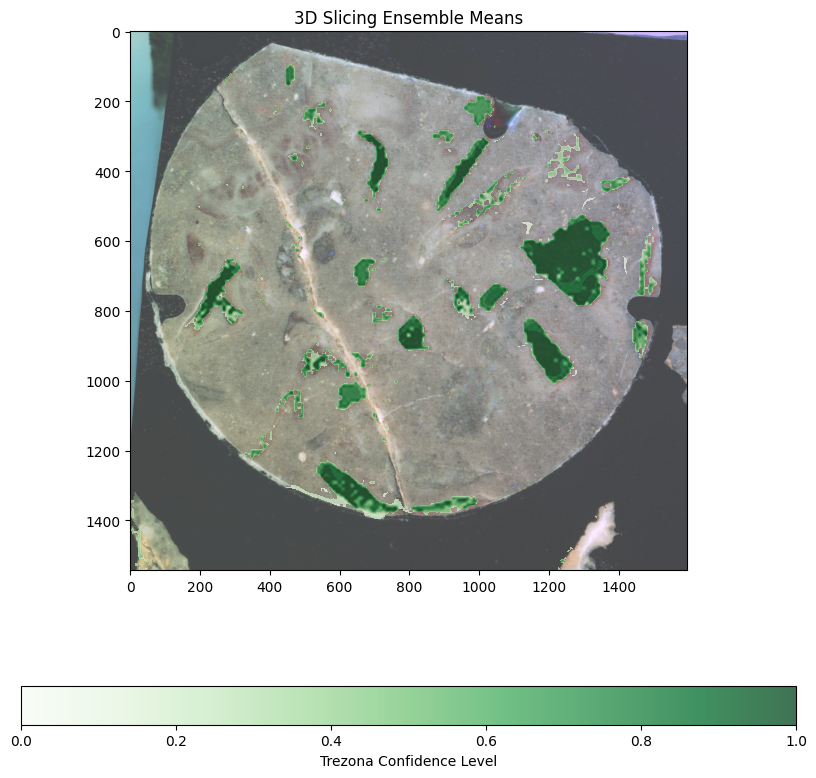

In [57]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
plt.imshow(testImg, alpha=0.75)
plt.imshow(np.ma.masked_where(stackedPix[0]<0.1, stackedPix[0]), alpha=0.75, cmap='Greens', vmin=0.0, vmax=1.0)
plt.title("3D Slicing Ensemble Means")
plt.colorbar(orientation="horizontal", label="Trezona Confidence Level", cmap='Greens')


plt.show()

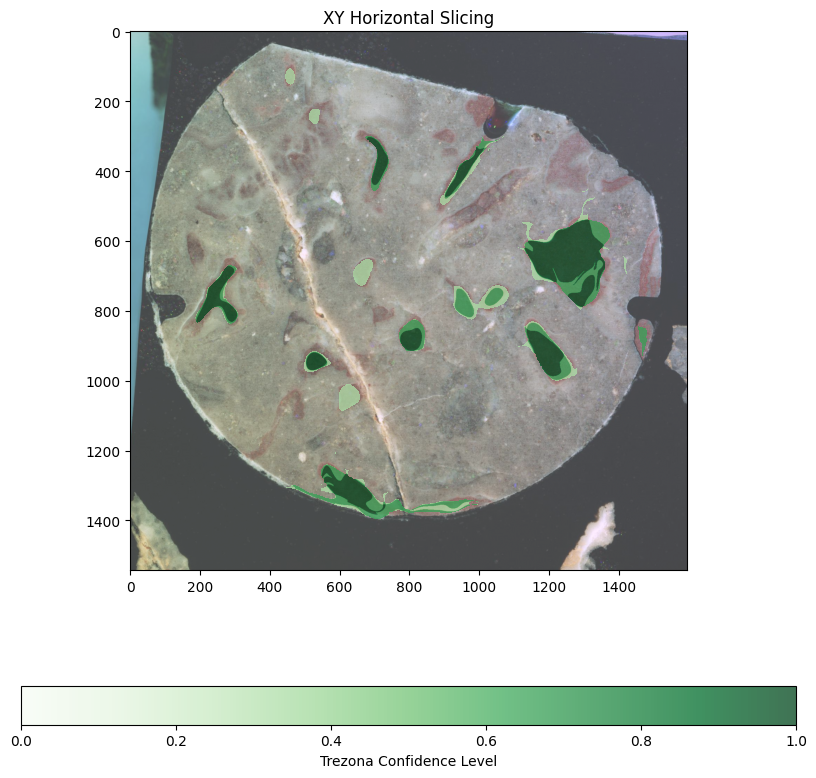

In [44]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
plt.imshow(testImg, alpha=0.75)
plt.imshow(np.ma.masked_where(xy[0]<0.1, xy[0]), alpha=0.75, cmap='Greens', vmin=0.0, vmax=1.0)
plt.title("XY Horizontal Slicing")
plt.colorbar(orientation="horizontal", label="Trezona Confidence Level", cmap='Greens')


plt.show()

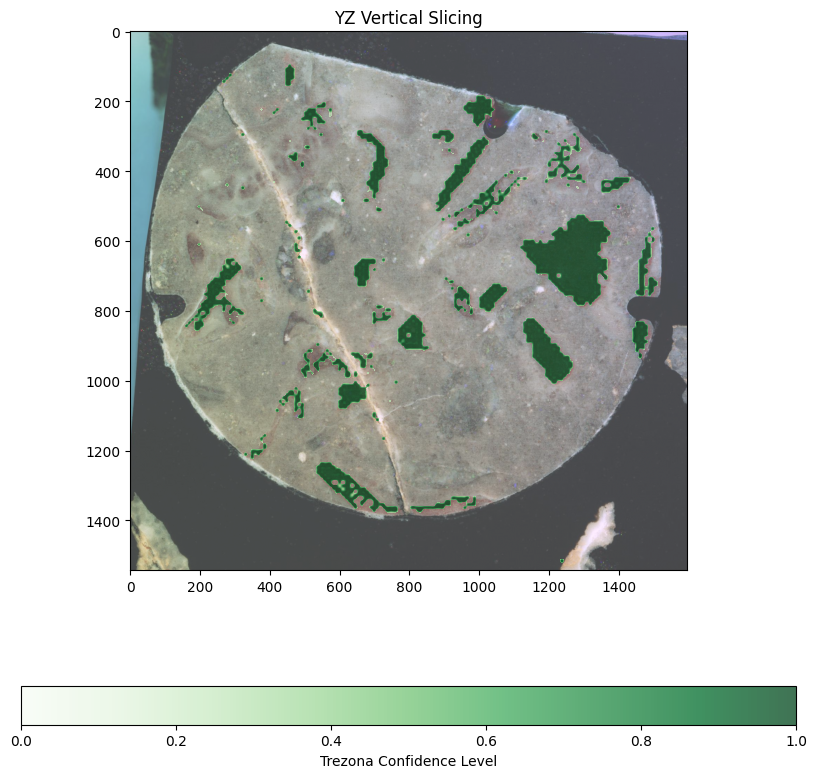

In [52]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
plt.imshow(testImg, alpha=0.75)
plt.imshow(np.ma.masked_where(yz[0]<0.1, yz[0]), alpha=0.75, cmap='Greens', vmin=0.0, vmax=1.0)
plt.title("YZ Vertical Slicing")
plt.colorbar(orientation="horizontal", label="Trezona Confidence Level", cmap='Greens')


plt.show()

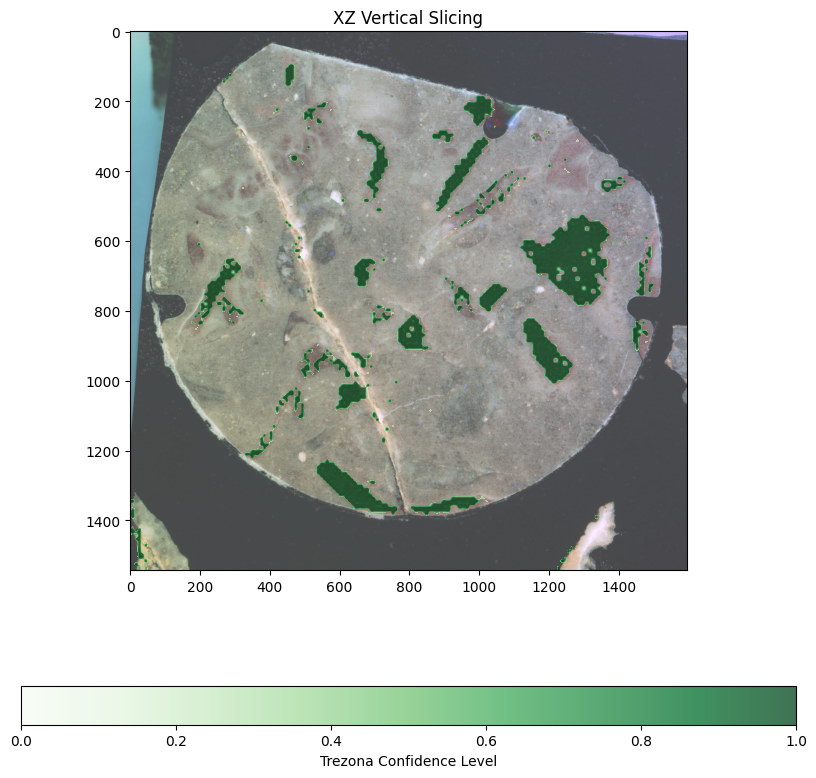

In [53]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
plt.imshow(testImg, alpha=0.75)
plt.imshow(np.ma.masked_where(xz[0]<0.1, xz[0]), alpha=0.75, cmap='Greens', vmin=0.0, vmax=1.0)
plt.title("XZ Vertical Slicing")
plt.colorbar(orientation="horizontal", label="Trezona Confidence Level", cmap='Greens')


plt.show()

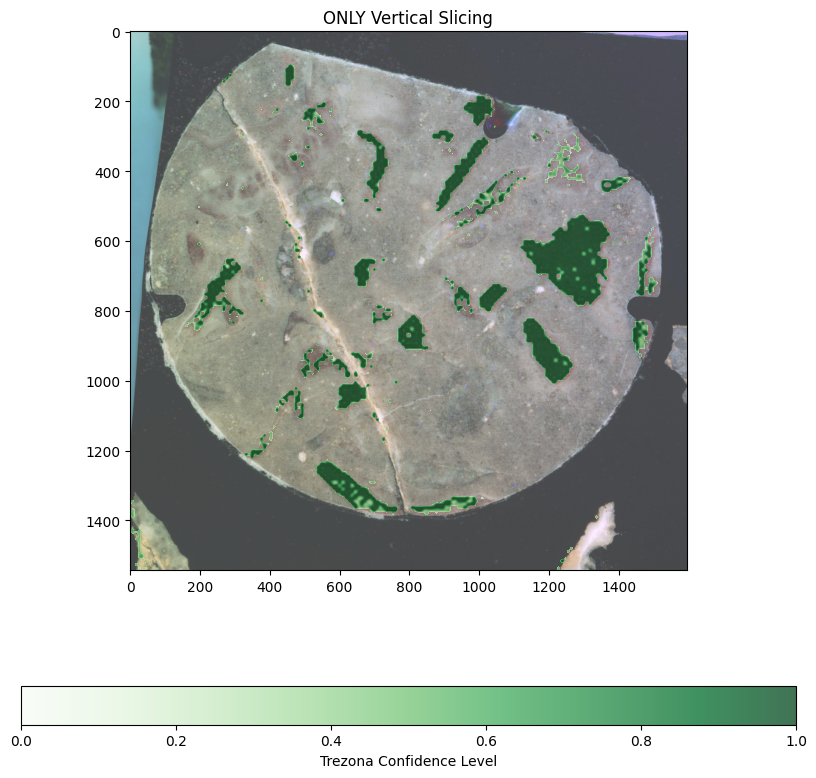

In [59]:
vertPix = (xz + yz) / 2.0
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
plt.imshow(testImg, alpha=0.75)
plt.imshow(np.ma.masked_where(vertPix[0]<0.1, vertPix[0]), alpha=0.75, cmap='Greens', vmin=0.0, vmax=1.0)
plt.title("ONLY Vertical Slicing")
plt.colorbar(orientation="horizontal", label="Trezona Confidence Level", cmap='Greens')


plt.show()